In [3]:
from garminconnect import Garmin
import datetime
from datetime import date
import pandas as pd
import logging
import seaborn as sns
import numpy as np

# --- Recommended way to create a dynamic log filename ---
# Get the current datetime
now = datetime.datetime.now()

# Format it into a string safe for filenames
# Example: "2025-07-11_14-35-12.log"
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")

# Use this formatted string in your FileHandler
log_filename = f"garmin_data_script_{timestamp_str}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_filename), # Use the dynamically generated filename
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

# Replace with your Garmin Connect credentials
USERNAME = "racurry93@gmail.com"
PASSWORD = "Bravesr1"
try:
    api = Garmin(USERNAME, PASSWORD)
    logger.info("Attempting to log in to Garmin Connect...")
    api.login()
    logger.info("Login successful.")
except Exception as e:
    logger.critical(f"A critical error occurred during script execution: {e}", exc_info=True)
    logger.critical("Script terminated due to critical error.")

today = date.today()
prior_year = today.year - 1
st_dt = date(prior_year, 1, 1).isoformat()
end_dt = today.isoformat()

logger.info(f"Script started. Fetching data from {st_dt} to {end_dt}")

In [5]:
from datetime import date, timedelta

def get_iso_date_range(start_date_str: str, end_date_str: str) -> list[str]:
    """
    Generates a list of dates in ISO format (YYYY-MM-DD) between a
    specified start and end date (inclusive).

    Args:
        start_date_str: The beginning date as a string in 'YYYY-MM-DD' format.
        end_date_str: The end date as a string in 'YYYY-MM-DD' format.

    Returns:
        A list of date strings in ISO format.
    """
    date_list = []

    # Convert string dates to date objects
    # This allows arithmetic operations on dates
    start_date = date.fromisoformat(start_date_str)
    end_date = date.fromisoformat(end_date_str)

    # Ensure start_date is not after end_date
    if start_date > end_date:
        raise ValueError("Start date cannot be after end date.")

    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.isoformat())
        current_date += timedelta(days=1) # Move to the next day

    return date_list

def get_rhr_value(metric_list):
    """
    Extracts the 'value' from the first dictionary in a list,
    handling cases of empty lists or non-list/non-dict entries.
    """
    if isinstance(metric_list, list) and len(metric_list) > 0:
        # Ensure the first item in the list is a dictionary
        if isinstance(metric_list[0], dict):
            # Use .get() for safe access to 'value'
            return metric_list[0].get('value')
    return None # Return None if data is not in the expected format

date_range = get_iso_date_range(st_dt, end_dt)

In [9]:
total_sleep_df = pd.DataFrame()
missed_dts = []
for dt in date_range:
    logger.info(f"Fetching data for period: {dt}")
    try:
        ##Sleep DF
        sleep_df = pd.DataFrame(api.get_sleep_data(dt))
        staging_sleep_df = sleep_df.iloc[:, [0]].T
        staging_sleep_df.reset_index(inplace=True)
        staging_sleep_df.drop(['index'], axis=1, inplace=True)
        staging_sleep_df['Date'] = dt
        additional_sleep_df = sleep_df.reset_index().iloc[:,2:].drop_duplicates()
        additional_sleep_df['Date'] = dt
        additional_sleep_df
        sleep_df = staging_sleep_df.merge(additional_sleep_df,  left_on='Date', right_on='Date', how='inner')
        first_record_sleep_scores = sleep_df['sleepScores'].iloc[0]
        first_record_other_data = sleep_df.iloc[0].drop('sleepScores').to_dict()
        # Flatten the sleepScores dictionary
        normalized_scores = pd.json_normalize(first_record_sleep_scores, sep='_')
        # Create a DataFrame for other simple columns
        other_data_df = pd.DataFrame([first_record_other_data])
        # Combine them. Use the same index to ensure they line up for concat.
        sleep_df = pd.concat([other_data_df, normalized_scores], axis=1)
        sleep_df.drop_duplicates(inplace=True)
        total_sleep_df = pd.concat([total_sleep_df, sleep_df], axis=0)
    except Exception as e:
      missed_dts.append(dt)
for missed_date in missed_dts:
  sleep_df = pd.DataFrame(api.get_sleep_data(dt))
  staging_sleep_df = sleep_df.iloc[:, [0]].T
  staging_sleep_df.reset_index(inplace=True)
  staging_sleep_df.drop(['index'], axis=1, inplace=True)
  staging_sleep_df['Date'] = dt
  additional_sleep_df = sleep_df.reset_index().iloc[:,2:]
  additional_sleep_df.head()

ValueError: All arrays must be of the same length

In [ ]:

total_sleep_df = pd.DataFrame()
total_bb_df = pd.DataFrame()
total_rhr_df = pd.DataFrame()
total_steps_df = pd.DataFrame()
total_user_df = pd.DataFrame()
for dt in date_range:
    logger.info(f"Fetching data for period: {dt}")
    try:
        ##Sleep DF
        sleep_df = pd.DataFrame(api.get_sleep_data(dt))
        staging_sleep_df = sleep_df.iloc[:, [0]].T
        staging_sleep_df.reset_index(inplace=True)
        staging_sleep_df.drop(['index'], axis=1, inplace=True)
        staging_sleep_df['Date'] = dt
        additional_sleep_df = sleep_df.reset_index().iloc[:,2:].drop_duplicates()
        additional_sleep_df['Date'] = dt
        additional_sleep_df
        sleep_df = staging_sleep_df.merge(additional_sleep_df,  left_on='Date', right_on='Date', how='inner')
        first_record_sleep_scores = sleep_df['sleepScores'].iloc[0]
        first_record_other_data = sleep_df.iloc[0].drop('sleepScores').to_dict()
        # Flatten the sleepScores dictionary
        normalized_scores = pd.json_normalize(first_record_sleep_scores, sep='_')
        # Create a DataFrame for other simple columns
        other_data_df = pd.DataFrame([first_record_other_data])
        # Combine them. Use the same index to ensure they line up for concat.
        sleep_df = pd.concat([other_data_df, normalized_scores], axis=1)
        sleep_df.drop_duplicates(inplace=True)
        total_sleep_df = pd.concat([total_sleep_df, sleep_df], axis=0)


        ##BodyBattery DF
        bb_df = pd.DataFrame(api.get_body_battery(dt))
        bb_df = bb_df[['date','charged','drained']]
        bb_df.rename({'date':'Date'}, axis=1, inplace=True)
        total_bb_df = pd.concat([total_bb_df, bb_df[['Date','charged','drained']]], axis=0)

        ##RestingHR DF
        rhr_df = pd.DataFrame(api.get_rhr_day(dt))
        #rhr_df['allMetricsClean'] = rhr_df['allMetrics'].apply(
        #    lambda x: x.get('WELLNESS_RESTING_HEART_RATE') if isinstance(x, dict) else None
        #)
        # Apply the function to the 'allMetricsClean' column
        #rhr_df['resting_heart_rate_value'] = rhr_df['allMetricsClean'].apply(get_rhr_value)
        rhr_df.rename({'statisticsStartDate':'Date'}, axis=1, inplace=True)
        total_rhr_df = pd.concat([total_rhr_df, rhr_df], axis=0)


        ##Steps DF
        steps_df = pd.DataFrame(api.get_steps_data(dt))
        steps_df['Date'] = pd.to_datetime(steps_df['startGMT']).dt.strftime('%Y-%m-%d')
        steps_df = steps_df.groupby(['Date'])[['steps','pushes']].sum().head()
        steps_df.reset_index(inplace=True)
        total_steps_df = pd.concat([total_steps_df, steps_df], axis=0)

        ##User Summary Data
        user = pd.DataFrame(api.get_user_summary(dt))
        user.reset_index(inplace=True)
        user = user.loc[user['index'] == 'typeId'].drop('index', axis=1)
        total_user_df = pd.concat([total_user_df, user], axis=0)
    except Exception as e:
        logger.error(f"Unexpected error during data processing: {e}", exc_info=True)


cols_mapping = total_sleep_df.columns.drop('Date').to_list()
cols_mapping = ['Date'] + cols_mapping
total_sleep_df = total_sleep_df[cols_mapping]
total_user_df.rename({'calendarDate':'Date'}, axis=1, inplace=True)

2025-07-31 08:08:39,916 - __main__ - INFO - Fetching data for period: 2024-01-01
2025-07-31 08:08:40,664 - __main__ - INFO - Fetching data for period: 2024-01-02
2025-07-31 08:08:41,291 - __main__ - INFO - Fetching data for period: 2024-01-03
2025-07-31 08:08:41,791 - __main__ - INFO - Fetching data for period: 2024-01-04
2025-07-31 08:08:42,312 - __main__ - INFO - Fetching data for period: 2024-01-05
2025-07-31 08:08:42,877 - __main__ - INFO - Fetching data for period: 2024-01-06
2025-07-31 08:08:43,442 - __main__ - INFO - Fetching data for period: 2024-01-07
2025-07-31 08:08:43,992 - __main__ - INFO - Fetching data for period: 2024-01-08
2025-07-31 08:08:44,582 - __main__ - INFO - Fetching data for period: 2024-01-09
2025-07-31 08:08:45,124 - __main__ - INFO - Fetching data for period: 2024-01-10
2025-07-31 08:08:45,757 - __main__ - INFO - Fetching data for period: 2024-01-11
2025-07-31 08:08:46,258 - __main__ - INFO - Fetching data for period: 2024-01-12
2025-07-31 08:08:46,809 - __

In [ ]:
mn = min(date_range)
mx = max(date_range)
total_activity_df = pd.DataFrame()
logger.info("Getting activities data...")
try:
    activities = api.get_activities_by_date(mn, mx)
    activity_df = pd.DataFrame(activities)
    total_activity_df = pd.concat([total_activity_df, activity_df], axis=0)

except Exception as e:
    logger.error(f"Error during activities data pull: {e}", exc_info=True)

total_activity_df['typeKey_clean'] = total_activity_df['activityType'].apply(
    lambda x: x.get('typeKey') if isinstance(x, dict) else None
)
total_activity_df.drop(['activityType','eventType'], axis=1, inplace=True)
total_activity_df['Date'] = pd.to_datetime(total_activity_df['startTimeLocal']).dt.strftime('%Y-%m-%d')
cols_mapping = total_activity_df.columns.drop('Date').to_list()
cols_mapping = ['Date'] + cols_mapping
total_activity_df = total_activity_df[cols_mapping]

2025-07-30 15:06:18,853 - __main__ - INFO - Getting activities data...


In [ ]:
#hrv_df = api.get_hrv_data(dt)
#pd.DataFrame(hrv_df['hrvSummary']).head()

In [ ]:
## Total DFs Listed Below
#1.) total_activity_df ##Activities data
#2.) total_sleep_df ##Sleep data
#3.) total_bb_df ##Body Battery data
#4.) total_rhr_df #Resting HR data
#5.) total_steps_df #Steps data
#6.) total_user_df #User summary data

df_list = [total_activity_df, total_sleep_df, total_bb_df, total_rhr_df, total_steps_df, total_user_df]

try:
    logger.info("Starting combination of dataframes...")
    total_df = pd.DataFrame(date_range)
    total_df.rename({0:'Date'}, axis=1, inplace=True)
    for stage_df in df_list:
        total_df = total_df.merge(stage_df, left_on='Date', right_on='Date', how='left')
except Exception as e:
    logger.error(f"Error during combination process of all datasets {e}", exc_info=True)


2025-07-30 15:06:20,409 - __main__ - INFO - Starting combination of dataframes...


In [ ]:
total_df['ActivityStartHour'] = pd.to_datetime(total_df['startTimeLocal']).dt.strftime('%H')
total_df.rename({'steps_x':'ActivitySteps'}, inplace=True, axis=1)

In [ ]:
cols_to_drop = ['latestRespirationValue','lowestRespirationValue_y','highestRespirationValue_y','latestRespirationTimeGMT',
                'respirationAlgorithmVersion','latestSpo2ReadingTimeLocal','latestSpo2ReadingTimeGmt','startTimeGMT',
                'activityId','ownerId','ownerProfileImageUrlSmall','hasImages','ownerProfileImageUrlMedium','ownerProfileImageUrlLarge',
                'privacy','hasVideo','timeZoneId','deviceId','endTimeGMT','favorite','decoDive','workoutId','calendarDate','id',
                'deviceRemCapable','retro','sleepStartTimestampGMT','userProfilePK','skinTempDataExists','userProfileId_x','statisticsEndDate',
                'userProfileId_y','userDailySummaryId','rule','uuid','wellnessStartTimeGmt','wellnessEndTimeGmt','privacyProtected',
                'source','lastSyncTimestampGMT','bodyBatteryVersion','startTimeLocal','hasPolyline','userRoles','userPro',
                'beginTimestamp','sportTypeId','summarizedDiveInfo','manufacturer','hasSplits','qualifyingDive','hasHeatMap','pr',
                'purposeful','parent','manualActivity','autoCalcCalories','elevationCorrected','atpActivity','summarizedExerciseSets',
                'sleepEndTimestampGMT','sleepEndTimestampLocal','sleepQualityTypePK','sleepResultTypePK','sleepStartTimestampLocal',
                'sleepVersion','sleepWindowConfirmationType','sleepLevels','sleepScorePersonalizedInsight','groupedMetrics',
                'wellnessStartTimeLocal','wellnessEndTimeLocal','durationInMilliseconds','wellnessDescription','averageSpo2',
                'lowestSpo2','latestSpo2','splitSummaries','allMetrics','allMetricsClean','sleepFromDevice','startLatitude','startLongitude',
                'endLatitude','endLongitude','ownerDisplayName','autoSleepStartTimestampGMT','autoSleepEndTimestampGMT','totalDuration_optimalStart',
                'totalDuration_optimalEnd','optimalStart','stress_optimalEnd','remPercentage_optimalStart','remPercentage_optimalEnd',
                'remPercentage_idealStartInSeconds','remPercentage_idealEndInSeconds','restlessness_optimalStart','restlessness_optimalEnd',
                'lightPercentage_optimalStart','lightPercentage_optimalEnd','lightPercentage_idealStartInSeconds','lightPercentage_idealEndInSeconds',
                'deepPercentage_optimalStart','deepPercentage_optimalEnd','deepPercentage_idealStartInSeconds','deepPercentage_idealEndInSeconds']
for col in cols_to_drop:
    try:
        total_df.drop(col, axis=1, inplace=True)
    except:
        print('Column does not exist')

logger.info("Pre-Processing finished.")

2025-07-30 15:06:20,870 - __main__ - INFO - Pre-Processing finished.


Column does not exist
Column does not exist


In [ ]:
total_df['ActivityPerformedToday'] = total_df['activityName'].isnull().apply(lambda x: 0 if x == True else 1)

In [ ]:
#total_activity_df = total_df.loc[total_df['ActivityPerformedToday'] == 1]
#total_noactivity_df = total_df.loc[total_df['ActivityPerformedToday'] == 0]


In [ ]:
cols_na = list(total_df.columns[total_df.isnull().sum() > 0])
for col in cols_na:
    print(f"{col}: % missing - {len(total_df.loc[total_df[col].isnull() == True]) / len(total_df)}")

activityName: % missing - 0.7158415841584158
distance: % missing - 0.7158415841584158
duration: % missing - 0.7158415841584158
elapsedDuration: % missing - 0.7158415841584158
movingDuration: % missing - 0.7237623762376237
elevationGain: % missing - 0.7455445544554455
elevationLoss: % missing - 0.7455445544554455
averageSpeed: % missing - 0.7158415841584158
maxSpeed: % missing - 0.7356435643564356
ownerFullName: % missing - 0.7158415841584158
calories: % missing - 0.7158415841584158
bmrCalories: % missing - 0.7237623762376237
averageHR: % missing - 0.7237623762376237
maxHR: % missing - 0.7158415841584158
ActivitySteps: % missing - 0.7277227722772277
aerobicTrainingEffect: % missing - 0.7158415841584158
anaerobicTrainingEffect: % missing - 0.7158415841584158
minTemperature: % missing - 0.7237623762376237
maxTemperature: % missing - 0.7237623762376237
minElevation: % missing - 0.7455445544554455
maxElevation: % missing - 0.7455445544554455
maxVerticalSpeed: % missing - 0.7534653465346535


In [ ]:
cols_to_drop_na = ['sleepWindowConfirmed','abnormalHeartRateAlertsCount','sleepMovement','burnedKilocalories','consumedKilocalories','bodyBatteryAtWakeTime']
print('-------Dropping Columns--------')
for col in cols_to_drop_na:
    total_df.drop(col, axis=1, inplace=True)

cols_to_fill_0 = ['totalSets','activeSets','totalReps','hrTimeInZone_1','hrTimeInZone_2','hrTimeInZone_3','hrTimeInZone_4','hrTimeInZone_5',
                  'maxRunningCadenceInStepsPerMinute','averageRunningCadenceInStepsPerMinute','avgStrideLength','vO2MaxValue',
                  'maxDoubleCadence','moderateIntensityMinutes_x','vigorousIntensityMinutes_x','elevationGain','elevationLoss',
                  'maxSpeed','minActivityLapDuration','ActivitySteps','unmeasurableSleepSeconds','steps_y','pushes',
                  'totalDistanceMeters','wellnessDistanceMeters','wellnessActiveKilocalories','netRemainingKilocalories',
                  'highlyActiveSeconds','activeSeconds','sedentarySeconds','intensityMinutesGoal','userFloorsAscendedGoal',
                  'moderateIntensityMinutes_y','vigorousIntensityMinutes_y','stressQualifier','measurableAwakeDuration','measurableAsleepDuration',
                  ]

print('-------Filling Columns w/0--------')
for col in cols_to_fill_0:
    total_df[col].fillna(0, inplace=True)

cols_to_fill_mean = ['minAvgHeartRate','maxAvgHeartRate','avgWakingRespirationValue','restingCaloriesFromActivity','averageMonitoringEnvironmentAltitude',
                     'ageGroup','movingDuration', 'bmrCalories','averageHR','minTemperature','maxTemperature','minElevation',
                     'maxElevation','maxVerticalSpeed','avgSleepStress','awakeCount','awakeSleepSeconds','deepSleepSeconds',
                     'highestRespirationValue_x','lightSleepSeconds','lowestRespirationValue_x','napTimeSeconds','remSleepSeconds',
                     'sleepTimeSeconds','remSleepData','bodyBatteryChange','restingHeartRate_x','overall_value','remPercentage_value',
                     'lightPercentage_value','deepPercentage_value','charged','drained','totalKilocalories','activeKilocalories',
                     'bmrKilocalories','wellnessKilocalories','remainingKilocalories','totalSteps','netCalorieGoal','dailyStepGoal',
                     'sleepingSeconds','floorsAscendedInMeters','floorsDescendedInMeters','floorsAscended','floorsDescended',
                     'minHeartRate','maxHeartRate','restingHeartRate_y','lastSevenDaysAvgRestingHeartRate','averageStressLevel',
                     'maxStressLevel','stressDuration','restStressDuration','activityStressDuration','uncategorizedStressDuration',
                     'totalStressDuration','lowStressDuration','mediumStressDuration','highStressDuration','stressPercentage',
                     'restStressPercentage','activityStressPercentage','uncategorizedStressPercentage','lowStressPercentage',
                     'mediumStressPercentage','highStressPercentage','bodyBatteryChargedValue','bodyBatteryDrainedValue',
                     'bodyBatteryHighestValue','bodyBatteryLowestValue','bodyBatteryMostRecentValue','bodyBatteryDuringSleep',
                    ]

print('-------Filling Columns w/mean--------')
cols_error = []
for col in cols_to_fill_0:
    try:
        mean_value = total_df[col].mean()
        total_df[col].fillna(mean_value, inplace=True)
    except Exception as e:
        print(f"{col} has an exception of {e} and wasn't converted")
        cols_error.append(col)



-------Dropping Columns--------
-------Filling Columns w/0--------
-------Filling Columns w/mean--------
stressQualifier has an exception of can only concatenate str (not "int") to str and wasn't converted


<Axes: >

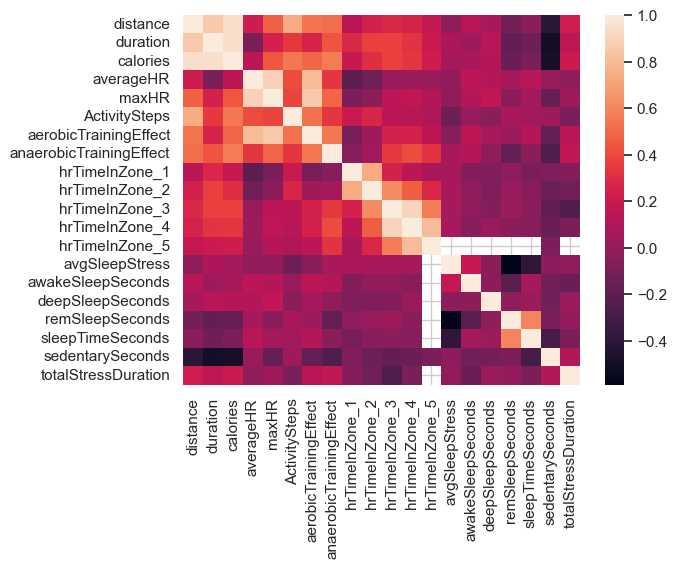

In [ ]:
sns.heatmap(total_df[['distance','duration','calories','averageHR','maxHR',
                               'ActivitySteps','aerobicTrainingEffect','anaerobicTrainingEffect',
                   'hrTimeInZone_1','hrTimeInZone_2','hrTimeInZone_3','hrTimeInZone_4','hrTimeInZone_5',
                   'avgSleepStress','awakeSleepSeconds','deepSleepSeconds','remSleepSeconds',
                   'sleepTimeSeconds','sedentarySeconds','totalStressDuration']].corr()
)

In [ ]:
# --- Part 1: Data Loading and Initial Preprocessing ---
print("1. Loading Data and Initial Preprocessing...")
df_cleaned = total_df.copy()

# Convert 'Date' column to datetime objects
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Sort by Date to prepare for time-series operations
df_cleaned = df_cleaned.sort_values(by='Date').reset_index(drop=True)

# Identify and drop columns that are almost entirely null or not useful
# These were identified in previous steps
columns_to_drop_initial = [
    'sleepMovement', 'burnedKilocalories', 'consumedKilocalories',
    'abnormalHeartRateAlertsCount', 'ownerFullName'
]

for col in columns_to_drop_initial:
    if col in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=[col])
        print(f"Dropped column: {col}")

# Impute 0 for metrics where NaN indicates absence of measurement
# These are typically activity-specific metrics that might not apply to all activity types
columns_to_fill_0 = [
    'movingDuration', 'elevationGain', 'elevationLoss', 'minElevation', 'maxElevation',
    'maxSpeed', 'maxVerticalSpeed', 'ActivitySteps', 'minTemperature', 'maxTemperature',
    'averageRunningCadenceInStepsPerMinute', 'maxRunningCadenceInStepsPerMinute',
    'avgStrideLength', 'vO2MaxValue', 'maxDoubleCadence', 'totalSets', 'activeSets',
    'totalReps', 'hrTimeInZone_1', 'hrTimeInZone_2', 'hrTimeInZone_3', 'hrTimeInZone_4',
    'hrTimeInZone_5', 'distance', 'duration', 'elapsedDuration', 'calories', 'averageSpeed',
    'maxHR', 'averageHR', 'aerobicTrainingEffect', 'anaerobicTrainingEffect', 'lapCount',
    'waterEstimated', 'activityTrainingLoad', 'minActivityLapDuration',
    'moderateIntensityMinutes_x', 'vigorousIntensityMinutes_x', 'steps_y', 'pushes',
    'totalKilocalories', 'activeKilocalories', 'bmrKilocalories', 'wellnessKilocalories',
    'remainingKilocalories', 'totalSteps', 'netCalorieGoal', 'totalDistanceMeters',
    'wellnessDistanceMeters', 'wellnessActiveKilocalories', 'netRemainingKilocalories',
    'dailyStepGoal', 'highlyActiveSeconds', 'activeSeconds', 'sedentarySeconds',
    'sleepingSeconds', 'moderateIntensityMinutes_y', 'vigorousIntensityMinutes_y',
    'floorsAscendedInMeters', 'floorsDescendedInMeters', 'floorsAscended', 'floorsDescended',
    'intensityMinutesGoal', 'userFloorsAscendedGoal', 'minHeartRate', 'maxHeartRate',
    'restingHeartRate_y', 'lastSevenDaysAvgRestingHeartRate', 'averageStressLevel',
    'maxStressLevel', 'stressDuration', 'restStressDuration', 'activityStressDuration',
    'uncategorizedStressDuration', 'totalStressDuration', 'lowStressDuration',
    'mediumStressDuration', 'highStressDuration', 'stressPercentage', 'restStressPercentage',
    'activityStressPercentage', 'uncategorizedStressPercentage', 'lowStressPercentage',
    'mediumStressPercentage', 'highStressPercentage', 'measurableAwakeDuration',
    'measurableAsleepDuration', 'minAvgHeartRate', 'maxAvgHeartRate', 'bodyBatteryChargedValue',
    'bodyBatteryDrainedValue', 'bodyBatteryHighestValue', 'bodyBatteryLowestValue',
    'bodyBatteryMostRecentValue', 'averageMonitoringEnvironmentAltitude',
    'restingCaloriesFromActivity', 'avgWakingRespirationValue'
]

for col in columns_to_fill_0:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(0)
        # print(f"Filled NaN in {col} with 0.")

# Impute remaining numerical columns with their median
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
for col in numerical_cols:
    if df_cleaned[col].isnull().any():
        median_val = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_val)
        # print(f"Filled NaN in numerical column {col} with median ({median_val}).")

cols_to_fill_cat_0 = ['activityName', 'locationName', 'trainingEffectLabel','aerobicTrainingEffectMessage',
                      'anaerobicTrainingEffectMessage']

for col in cols_to_fill_cat_0:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna('None')

# Impute remaining categorical columns with their mode
categorical_cols = df_cleaned.select_dtypes(include='object').columns
for col in categorical_cols:
    if df_cleaned[col].isnull().any():
        # Check if the column is entirely null before trying to get mode
        if not df_cleaned[col].isnull().all():
            mode_val = df_cleaned[col].mode()[0]
            df_cleaned[col] = df_cleaned[col].fillna(mode_val)
            # print(f"Filled NaN in categorical column {col} with mode ({mode_val}).")
        else:
            # If still entirely null, fill with 'Unknown'
            df_cleaned[col] = df_cleaned[col].fillna('Unknown')
            # print(f"Filled entirely NaN categorical column {col} with 'Unknown'.")

# Verify no more nulls
final_nulls = df_cleaned.isnull().sum()[df_cleaned.isnull().sum() > 0]
if final_nulls.empty:
    print("All null values have been successfully handled.")
else:
    print("\nRemaining null values after all imputations:")
    print(final_nulls)

def activitystart_cleanup(row):
    if row['ActivityPerformedToday'] == 1:
        return row['ActivityStartHour']
    else:
        return 0
df_cleaned['ActivityStartHour'] = df_cleaned.apply(activitystart_cleanup, axis=1)


# --- 1. Create 'activityType' Column ---
def categorize_activity(activity_name):
    activity_name_lower = str(activity_name).lower()
    if 'walking' in activity_name_lower:
        return 'Walking'
    elif 'running' in activity_name_lower or '5k' in activity_name_lower:
        return 'Running'
    elif 'golf' in activity_name_lower:
        return 'Golf'
    elif 'strength' in activity_name_lower or 'worko' in activity_name_lower:
        return 'Strength Training'
    elif 'cycling' in activity_name_lower:
        return 'Cycling'
    elif 'hiking' in activity_name_lower:
        return 'Hiking'
    elif 'multisport' in activity_name_lower:
        return 'Multisport' # Could be broken down further if 'multisport' has sub-types
    elif activity_name_lower == 'none':
        return 'No Activity'
    else:
        # Catch-all for any uncategorized activities. Review these after initial run.
        print(f"Warning: Uncategorized activity: {activity_name}")
        return 'Other'

df_cleaned['activityType'] = df_cleaned['activityName'].apply(categorize_activity)
df_cleaned.drop('activityName', axis=1, inplace=True)

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned = df_cleaned.sort_values(by='Date').reset_index(drop=True)
df_cleaned['ActivityPerformedToday'] = df_cleaned['ActivityPerformedToday'].astype(bool)

# Create a column for workout dates, fill non-workout days with NaT (Not a Time)
df_cleaned['workout_date'] = df_cleaned['Date'].where(df_cleaned['ActivityPerformedToday'])

# Fill forward the last workout date. `.ffill()` will propagate the last valid workout_date downwards.
df_cleaned['last_workout_date'] = df_cleaned['workout_date'].ffill()

# Calculate days since last workout. For days before any workout, this will be NaT.
df_cleaned['daysSinceLastWorkout'] = (df_cleaned['Date'] - df_cleaned['last_workout_date']).dt.days

# --- Convert sleep seconds to hours for better readability ---
sleep_cols_seconds = ['sleepTimeSeconds', 'deepSleepSeconds', 'remSleepSeconds', 'lightSleepSeconds', 'awakeSleepSeconds']
for col in sleep_cols_seconds:
    df_cleaned[col.replace('Seconds', 'Hours')] = df_cleaned[col] / 3600

df_cleaned['deepSleepPercentage'] = (df_cleaned['deepSleepSeconds'] / df_cleaned['sleepTimeSeconds']) * 100
df_cleaned['remSleepPercentage'] = (df_cleaned['remSleepSeconds'] / df_cleaned['sleepTimeSeconds']) * 100
df_cleaned['lightSleepPercentage'] = (df_cleaned['lightSleepSeconds'] / df_cleaned['sleepTimeSeconds']) * 100
df_cleaned['awakeSleepPercentage'] = (df_cleaned['awakeSleepSeconds'] / df_cleaned['sleepTimeSeconds']) * 100 # Might be high if sleepTimeSeconds includes awake time

# Time-based features
df_cleaned['day_of_week'] = df_cleaned['Date'].dt.day_name()
df_cleaned['is_weekend'] = df_cleaned['Date'].dt.weekday.isin([5, 6]).astype(int)
df_cleaned['month'] = df_cleaned['Date'].dt.month
df_cleaned['day_of_year'] = df_cleaned['Date'].dt.dayofyear
print("Created time-based features (day_of_week, is_weekend, month, day_of_year).")


1. Loading Data and Initial Preprocessing...
Dropped column: ownerFullName
All null values have been successfully handled.
Created time-based features (day_of_week, is_weekend, month, day_of_year).



Analysis 1: Sleep metrics on Workout vs. Non-Workout Days:

--- sleepTimeHours ---
ActivityPerformedToday
False    8.08
True     8.14
Name: sleepTimeHours, dtype: float64

--- deepSleepHours ---
ActivityPerformedToday
False    1.17
True     1.17
Name: deepSleepHours, dtype: float64

--- remSleepHours ---
ActivityPerformedToday
False    1.63
True     1.76
Name: remSleepHours, dtype: float64

--- deepSleepPercentage ---
ActivityPerformedToday
False    14.69
True     14.56
Name: deepSleepPercentage, dtype: float64

--- remSleepPercentage ---
ActivityPerformedToday
False    19.86
True     21.35
Name: remSleepPercentage, dtype: float64

Analysis 2: Sleep metrics by Days Since Last Workout:

--- sleepTimeHours by Days Since Last Workout Group ---
daysSinceLastWorkout_group
0 (Workout Day)    8.14
1                  7.98
2                  8.00
3+                 8.15
Name: sleepTimeHours, dtype: float64

--- deepSleepHours by Days Since Last Workout Group ---
daysSinceLastWorkout_group
0 (W

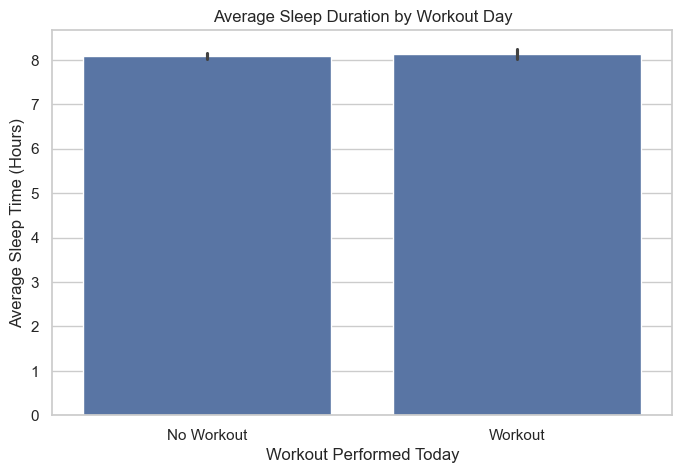

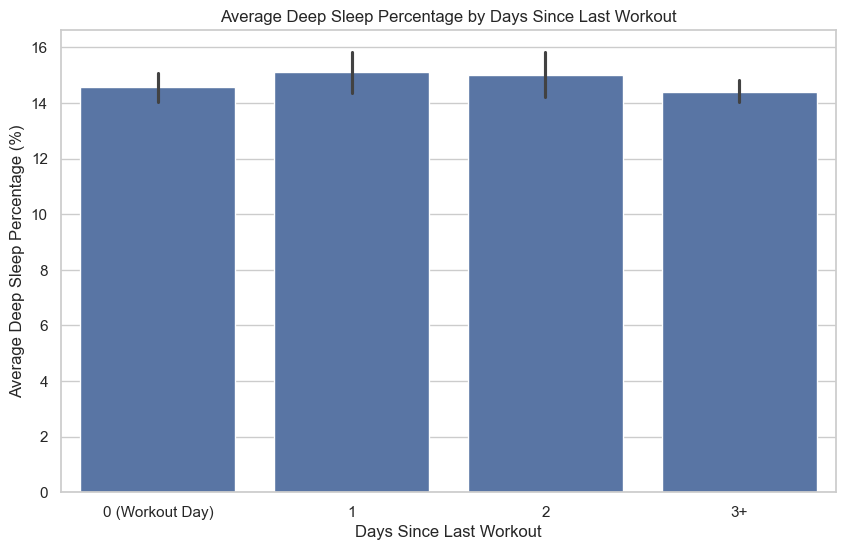

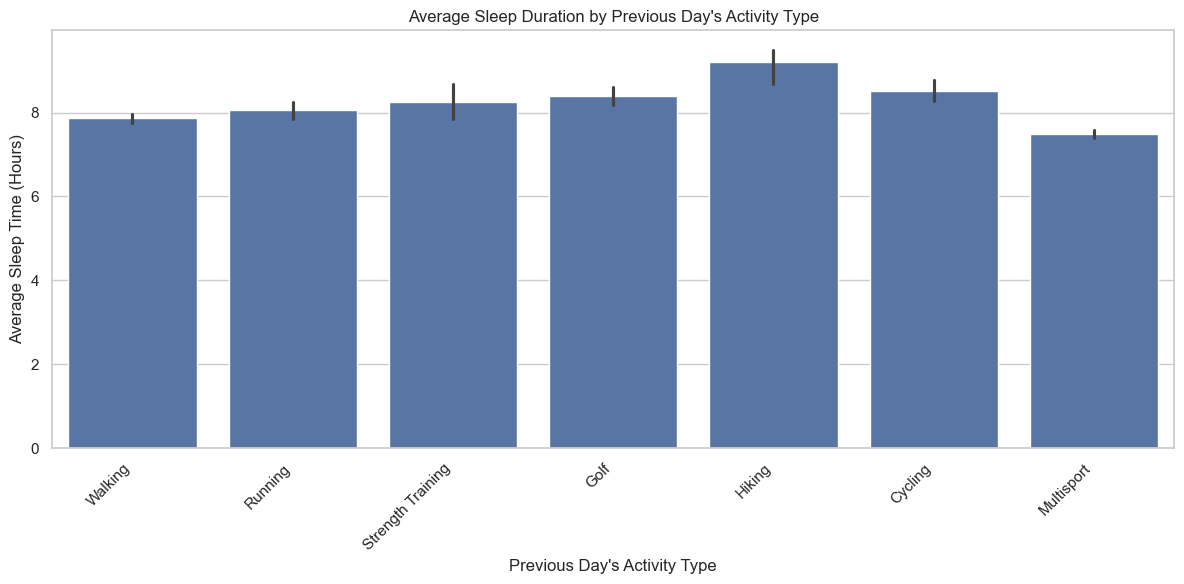

In [ ]:
# --- Analysis 1: Impact of ActivityPerformedToday on Sleep ---
print("\nAnalysis 1: Sleep metrics on Workout vs. Non-Workout Days:")
sleep_metrics = ['sleepTimeHours', 'deepSleepHours', 'remSleepHours', 'deepSleepPercentage', 'remSleepPercentage']
for metric in sleep_metrics:
    print(f"\n--- {metric} ---")
    print(df_cleaned.groupby('ActivityPerformedToday')[metric].mean().round(2))
    # You could also add standard deviation: .agg(['mean', 'std'])

# --- Analysis 2: Impact of Days Since Last Workout on Sleep ---
print("\nAnalysis 2: Sleep metrics by Days Since Last Workout:")
# Filter out days with no prior workout (where daysSinceLastWorkout is NaN)
df_analyzed = df_cleaned.dropna(subset=['daysSinceLastWorkout']).copy()
df_analyzed['daysSinceLastWorkout_group'] = df_analyzed['daysSinceLastWorkout'].apply(
    lambda x: '0 (Workout Day)' if x == 0 else ('1' if x == 1 else ('2' if x == 2 else '3+'))
)

# Sort the groups for better presentation if needed
group_order = ['0 (Workout Day)', '1', '2', '3+']
df_analyzed['daysSinceLastWorkout_group'] = pd.Categorical(df_analyzed['daysSinceLastWorkout_group'], categories=group_order, ordered=True)

for metric in sleep_metrics:
    print(f"\n--- {metric} by Days Since Last Workout Group ---")
    print(df_analyzed.groupby('daysSinceLastWorkout_group')[metric].mean().round(2))

# --- Analysis 3 (Conceptual): Impact of Specific Activity Type on *Next Day's* Sleep ---
# This requires shifting sleep data for analysis
activity_cols_for_merge = ['Date', 'activityType']
df_next_day_activity = df_cleaned[activity_cols_for_merge + ['ActivityPerformedToday']].copy()

# Add the 'next day' date column for the merge key
df_next_day_activity['Date_plus_1'] = df_next_day_activity['Date'] + pd.Timedelta(days=1)

# Filter for rows where an activity was performed and rename the date column for clarity
left_df = df_next_day_activity[df_next_day_activity['ActivityPerformedToday']].rename(columns={'Date': 'ActivityDate'})

# --- Step 2: Prepare the 'right' DataFrame with only the sleep metrics from the next day ---
# This is the same as before, as it's already selecting only the necessary columns.
right_df = df_cleaned[['Date'] + sleep_metrics].rename(columns={'Date': 'NextDaySleepDate'})

# --- Step 3: Perform the merge using the prepared DataFrames ---
# The merge will now join activity data from the current day with sleep data from the next day.
df_activity_impact = pd.merge(
    left_df,
    right_df,
    left_on='Date_plus_1',
    right_on='NextDaySleepDate',
    how='inner' # Only keep rows where we have both an activity and subsequent sleep
)

# --- Your original analysis loop will now work without modification ---
df_activity_impact_filtered = df_activity_impact[df_activity_impact['activityType'] != 'No Activity']

print("\nAnalysis 3: Sleep metrics by Previous Day's Activity Type:")
for metric in sleep_metrics:
    print(f"\n--- {metric} by Previous Day's Activity Type ---")
    if not df_activity_impact_filtered.empty:
        # This part of the code now works correctly because the `metric` columns
        # are coming exclusively from `right_df` and have not been duplicated.
        print(df_activity_impact_filtered.groupby('activityType')[metric].mean().round(2))
    else:
        print("No activity data for analysis on previous day's impact.")

# --- Visualizations (using matplotlib/seaborn - highly recommended for small sample sizes) ---
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Plot 1: Sleep Duration (Hours) by Workout Day
plt.figure(figsize=(8, 5))
sns.barplot(x='ActivityPerformedToday', y='sleepTimeHours', data=df_cleaned)
plt.title('Average Sleep Duration by Workout Day')
plt.xlabel('Workout Performed Today')
plt.ylabel('Average Sleep Time (Hours)')
plt.xticks([0, 1], ['No Workout', 'Workout'])
plt.show()

# Plot 2: Deep Sleep Percentage by Days Since Last Workout
plt.figure(figsize=(10, 6))
sns.barplot(x='daysSinceLastWorkout_group', y='deepSleepPercentage', data=df_analyzed)
plt.title('Average Deep Sleep Percentage by Days Since Last Workout')
plt.xlabel('Days Since Last Workout')
plt.ylabel('Average Deep Sleep Percentage (%)')
plt.show()

# Plot 3: Sleep Duration by Previous Day's Activity Type
if not df_activity_impact_filtered.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='activityType', y='sleepTimeHours', data=df_activity_impact_filtered)
    plt.title('Average Sleep Duration by Previous Day\'s Activity Type')
    plt.xlabel('Previous Day\'s Activity Type')
    plt.ylabel('Average Sleep Time (Hours)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

2025-07-30 15:20:49,387 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-30 15:20:49,394 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


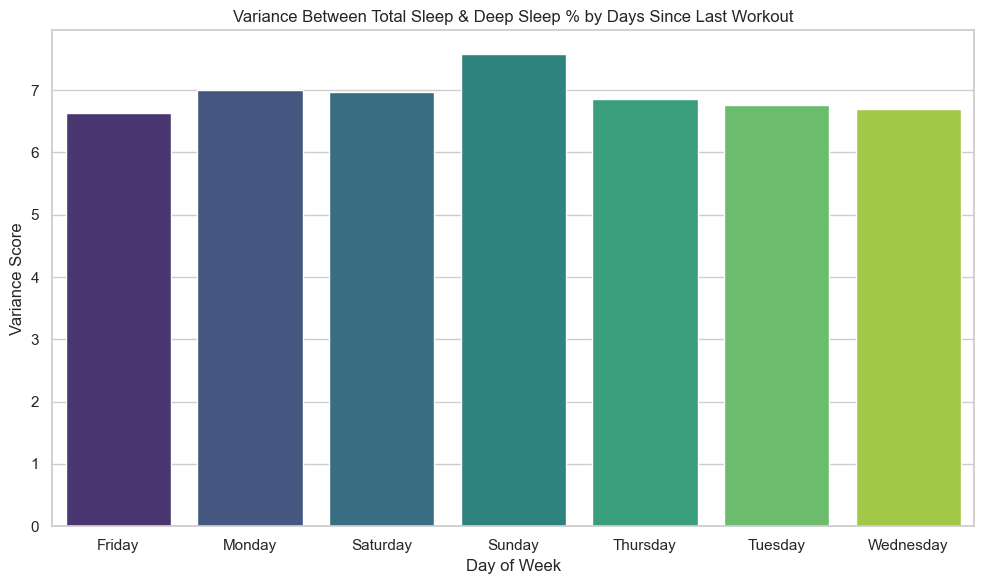

In [ ]:
# --- Data Preparation for Plot 1: Variance by Days Since Last Workout Group ---
# Group the data and calculate the mean for each sleep metric
df_grouped_days_since = df_analyzed.groupby('day_of_week')[['sleepTimeHours', 'deepSleepHours']].mean()

# Calculate the variance score (absolute difference)
df_grouped_days_since['variance_score'] = (
    df_grouped_days_since['sleepTimeHours'] - df_grouped_days_since['deepSleepHours']
).abs()


# --- Plot 1: Variance by Days Since Last Workout ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x=df_grouped_days_since.index,
    y=df_grouped_days_since['variance_score'],
    palette='viridis' # Choose a nice color palette
)
plt.title('Variance Between Total Sleep & Deep Sleep % by Days Since Last Workout')
plt.xlabel('Day of Week')
plt.ylabel('Variance Score')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
sleep_results = dict(df_analyzed.groupby('daysSinceLastWorkout_group').agg({'deepSleepPercentage':'mean'}).reset_index())
activity_sleep_results = dict(df_activity_impact_filtered.groupby('activityType').agg({'sleepTimeHours':'mean'}).reset_index())
dow_deep_sleep_results = dict(df_analyzed.groupby('day_of_week').agg({'deepSleepPercentage':'mean'}).reset_index())
df_grouped_days_since = df_grouped_days_since.reset_index()
df_grouped_days_since = df_grouped_days_since[['day_of_week','variance_score']]
df_grouped_days_since = dict(df_grouped_days_since)

{'day_of_week': 0       Friday
 1       Monday
 2     Saturday
 3       Sunday
 4     Thursday
 5      Tuesday
 6    Wednesday
 Name: day_of_week, dtype: object,
 'variance_score': 0    6.634145
 1    7.001252
 2    6.976757
 3    7.579347
 4    6.851038
 5    6.760694
 6    6.701828
 Name: variance_score, dtype: float64}

2025-07-30 15:06:22,643 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-30 15:06:22,649 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


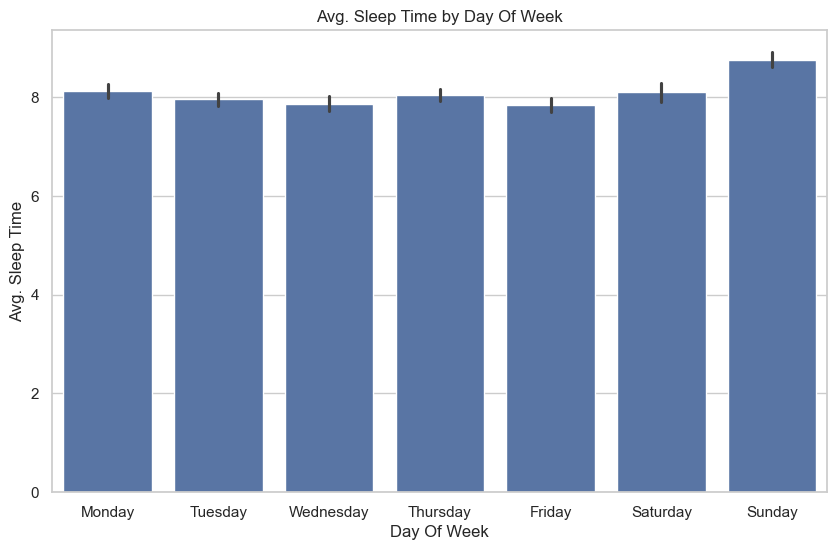

2025-07-30 15:06:22,914 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-30 15:06:22,920 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


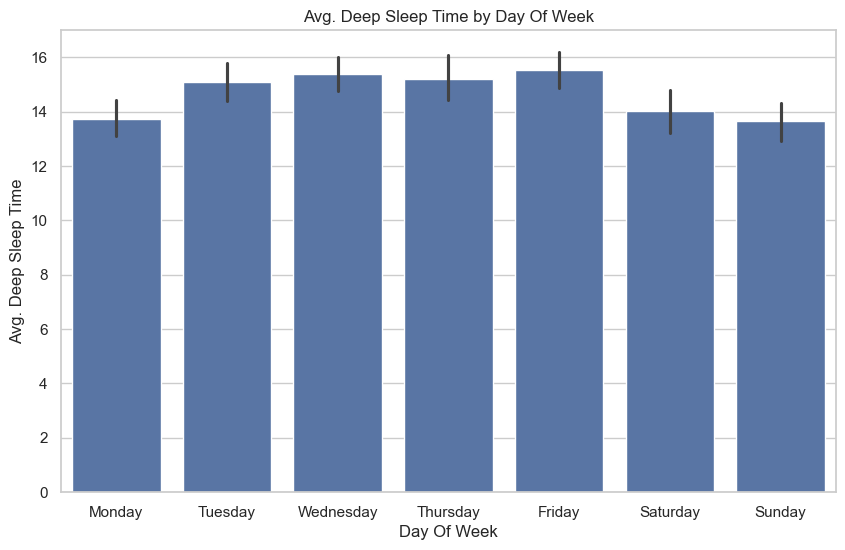

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='sleepTimeHours', data=df_cleaned)
plt.title('Avg. Sleep Time by Day Of Week')
plt.xlabel('Day Of Week')
plt.ylabel('Avg. Sleep Time')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='deepSleepPercentage', data=df_cleaned)
plt.title('Avg. Deep Sleep Time by Day Of Week')
plt.xlabel('Day Of Week')
plt.ylabel('Avg. Deep Sleep Time')
plt.show()

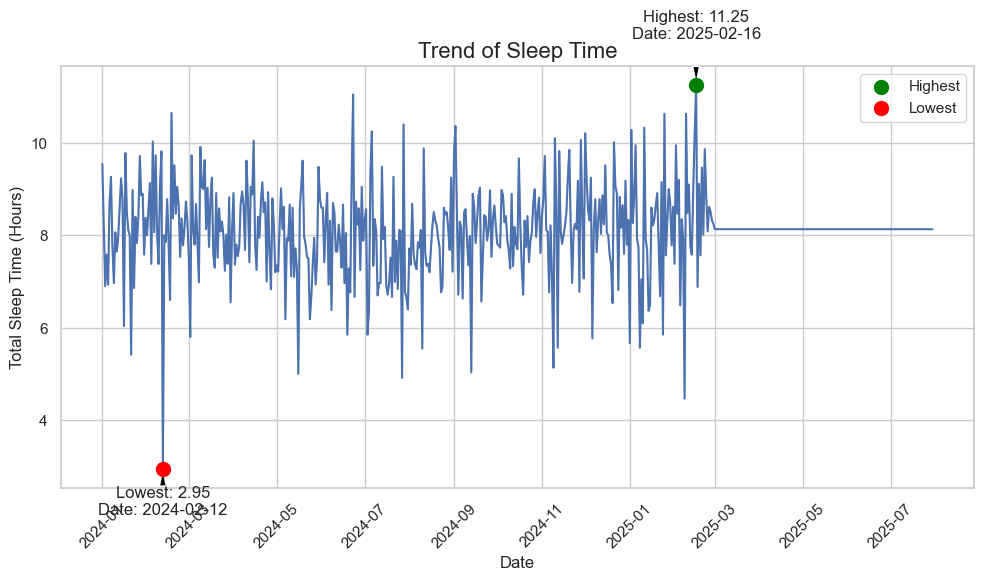

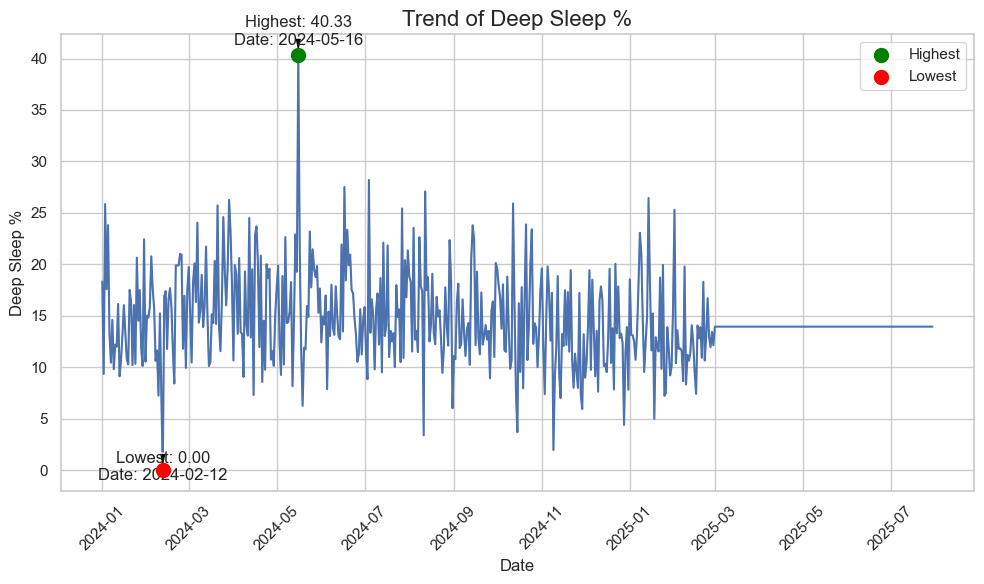

In [ ]:
# --- 2. Define a reusable plotting function ---
def plot_with_highlights(df, x_col, y_col, title, ylabel):
    """
    Plots a line graph and highlights the highest and lowest points.

    Args:
        df (pd.DataFrame): The input DataFrame.
        x_col (str): The column name for the x-axis (e.g., 'Date').
        y_col (str): The column name for the y-axis (e.g., 'sleepTimeHours').
        title (str): The title of the plot.
        ylabel (str): The label for the y-axis.
    """
    # Create figure and axes objects for more control
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the main line graph using Seaborn
    sns.lineplot(x=x_col, y=y_col, data=df, ax=ax, label='_nolegend_')

    # --- Find the highest and lowest points ---
    # Find the row index of the max and min values
    idx_max = df[y_col].idxmax()
    idx_min = df[y_col].idxmin()

    # Get the row data for these points
    max_point = df.loc[idx_max]
    min_point = df.loc[idx_min]

    # --- Highlight the points with a scatter plot ---
    # `zorder` ensures the point is drawn on top of the line
    ax.scatter(max_point[x_col], max_point[y_col], color='green', s=100, zorder=5, label='Highest')
    ax.scatter(min_point[x_col], min_point[y_col], color='red', s=100, zorder=5, label='Lowest')

    # --- Annotate the points with text ---
    # Annotation for the highest point
    ax.annotate(
        text=f"Highest: {max_point[y_col]:.2f}\nDate: {max_point[x_col].strftime('%Y-%m-%d')}",
        xy=(max_point[x_col], max_point[y_col]),
        xytext=(max_point[x_col], max_point[y_col] + 1),  # Offset text slightly above the point
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
        horizontalalignment='center'
    )
    # Annotation for the lowest point
    ax.annotate(
        text=f"Lowest: {min_point[y_col]:.2f}\nDate: {min_point[x_col].strftime('%Y-%m-%d')}",
        xy=(min_point[x_col], min_point[y_col]),
        xytext=(min_point[x_col], min_point[y_col] - 1),  # Offset text slightly below the point
        arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
        horizontalalignment='center'
    )

    # --- Set plot labels and titles ---
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_col, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Rotate x-axis tick labels for better readability
    ax.tick_params(axis='x', rotation=45)

    # Add a legend
    ax.legend(loc='best')

    # Adjust layout to prevent labels from being cut off
    plt.tight_layout()
    plt.show()

# --- 3. Call the function for your two plots ---
plot_with_highlights(
    df=df_cleaned,
    x_col='Date',
    y_col='sleepTimeHours',
    title='Trend of Sleep Time',
    ylabel='Total Sleep Time (Hours)'
)

plot_with_highlights(
    df=df_cleaned,
    x_col='Date',
    y_col='deepSleepPercentage',
    title='Trend of Deep Sleep %',
    ylabel='Deep Sleep %'
)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("Starting Garmin Data Predictive Analytics Script...\n")

# --- Part 2: Feature Engineering ---
print("\n2. Performing Feature Engineering...")

# Create 'is_workout_day' flag
# A simple heuristic: if duration > 0 and activityName is not 'Sleep'
df_cleaned['is_workout_day'] = (df_cleaned['duration'] > 0).astype(int)
print("Created 'is_workout_day' feature.")

# Lagged Features (Previous day's metrics)
# Crucial for predicting future states based on past performance/recovery
# Ensure data is sorted by Date for correct lagging
df_cleaned = df_cleaned.sort_values(by='Date').reset_index(drop=True)

lag_features = [
    'sleepTimeSeconds', 'deepSleepSeconds', 'remSleepSeconds', 'sleepScoreFeedback',
    'bodyBatteryMostRecentValue', 'restingHeartRate_y', 'averageStressLevel',
    'totalKilocalories', 'is_workout_day'
]

for feature in lag_features:
    df_cleaned[f'prev_day_{feature}'] = df_cleaned.groupby('Date')[feature].transform(lambda x: x.shift(1))
    # Fill NaNs for the first day(s) of lagged features.
    # For sleep/body battery, the first day might not have a 'previous day'.
    # We can fill with median or mean of the entire column, or 0 if it makes sense.
    # For simplicity, filling with median here.
    if df_cleaned[f'prev_day_{feature}'].isnull().any():
        if df_cleaned[f'prev_day_{feature}'].dtype == 'object':
            df_cleaned[f'prev_day_{feature}'] = df_cleaned[f'prev_day_{feature}'].fillna(df_cleaned[f'prev_day_{feature}'].mode()[0])
        else:
            df_cleaned[f'prev_day_{feature}'] = df_cleaned[f'prev_day_{feature}'].fillna(df_cleaned[f'prev_day_{feature}'].median())

print("Created lagged features (e.g., prev_day_sleepTimeSeconds, prev_day_bodyBatteryMostRecentValue).")

# Derived Metrics
df_cleaned['sleep_efficiency'] = df_cleaned['deepSleepSeconds'] + df_cleaned['remSleepSeconds'] / df_cleaned['sleepTimeSeconds']
df_cleaned['calories_per_minute'] = df_cleaned['calories'] / df_cleaned['duration'].replace(0, np.nan) # Avoid division by zero
df_cleaned['calories_per_minute'] = df_cleaned['calories_per_minute'].fillna(0) # Fill NaN from division by zero with 0
print("Created derived metrics (sleep_efficiency, calories_per_minute).")

# Categorical Encoding
# Identify all object columns for encoding
categorical_cols_for_encoding = df_cleaned.select_dtypes(include='object').columns.tolist()

# Special handling for sleepScoreFeedback for classification target later
# Map sleepScoreFeedback to a simpler binary target for one of the classification tasks
df_cleaned['sleepScoreFeedback_binary'] = df_cleaned['sleepScoreFeedback'].apply(
    lambda x: 'Positive' if 'POSITIVE' in str(x).upper() or 'GOOD' in str(x).upper() or 'EXCELLENT' in str(x).upper() else 'Negative'
)
if 'sleepScoreFeedback' in categorical_cols_for_encoding:
    categorical_cols_for_encoding.remove('sleepScoreFeedback') # Remove original as we'll use binary for prediction

# Apply One-Hot Encoding for the remaining categorical features
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols_for_encoding, drop_first=True)
print(f"Applied One-Hot Encoding to categorical features: {categorical_cols_for_encoding}")

# Drop original Date column as it's been used for feature engineering
df_cleaned = df_cleaned.drop(columns=['Date'])
print("Dropped original 'Date' column.")

# --- Part 3: Predictive Analytics - Problem 1: Predicting bodyBatteryChange (Regression) ---
print("\n3. Predicting bodyBatteryChange (Regression Task)")

# Define target and features
target_bb_change = 'bodyBatteryChange'
features_bb_change = [
    'sleepTimeSeconds', 'deepSleepSeconds', 'remSleepSeconds', 'sleep_efficiency',
    'restingHeartRate_y', 'averageStressLevel', 'totalKilocalories',
    'prev_day_bodyBatteryMostRecentValue', 'prev_day_sleepTimeSeconds',
    'prev_day_restingHeartRate_y', 'prev_day_averageStressLevel',
    'day_of_year', 'is_weekend', 'month', 'is_workout_day'
]

# Ensure all features exist in the dataframe
features_bb_change = [f for f in features_bb_change if f in df_cleaned.columns]
X_bb_change = df_cleaned[features_bb_change]
y_bb_change = df_cleaned[target_bb_change]

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X_bb_change):
    X_train, X_test = X_bb_change.iloc[train_index], X_bb_change.iloc[test_index]
    y_train, y_test = y_bb_change.iloc[train_index], y_bb_change.iloc[test_index]

    # Create a pipeline with scaling and RandomForestRegressor
    model_bb_change = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    model_bb_change.fit(X_train, y_train)
    y_pred = model_bb_change.predict(X_test)

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n  Fold Results for bodyBatteryChange Prediction:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R-squared: {r2:.2f}")

    # Feature Importance (from the last fold's model)
    feature_importances = model_bb_change.named_steps['regressor'].feature_importances_
    features_df = pd.DataFrame({'Feature': features_bb_change, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)
    print("\n  Top 5 Feature Importances for bodyBatteryChange:")
    print(features_df.head(5))

# --- Part 4: Predictive Analytics - Problem 2: Predicting totalKilocalories (Regression) ---
print("\n4. Predicting totalKilocalories (Regression Task)")

# Define target and features
target_kcal = 'totalKilocalories'
features_kcal = [
    'duration', 'distance', 'averageHR', 'maxHR', 'ActivitySteps', 'calories_per_minute',
    'is_workout_day', 'sleepTimeSeconds', 'bodyBatteryMostRecentValue',
    'restingHeartRate_y', 'averageStressLevel', 'day_of_year', 'is_weekend', 'month'
]

# Ensure all features exist in the dataframe
features_kcal = [f for f in features_kcal if f in df_cleaned.columns]
X_kcal = df_cleaned[features_kcal]
y_kcal = df_cleaned[target_kcal]

for train_index, test_index in tscv.split(X_kcal):
    X_train, X_test = X_kcal.iloc[train_index], X_kcal.iloc[test_index]
    y_train, y_test = y_kcal.iloc[train_index], y_kcal.iloc[test_index]

    model_kcal = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    model_kcal.fit(X_train, y_train)
    y_pred = model_kcal.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"\n  Fold Results for totalKilocalories Prediction:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R-squared: {r2:.2f}")

    feature_importances = model_kcal.named_steps['regressor'].feature_importances_
    features_df = pd.DataFrame({'Feature': features_kcal, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)
    print("\n  Top 5 Feature Importances for totalKilocalories:")
    print(features_df.head(5))

# --- Part 5: Predictive Analytics - Problem 3: Predicting sleepScoreFeedback (Classification) ---
print("\n5. Predicting sleepScoreFeedback (Classification Task)")

# Define target and features
target_sleep_feedback = 'sleepScoreFeedback_binary'
features_sleep_feedback = [
    'sleepTimeSeconds', 'deepSleepSeconds', 'remSleepSeconds', 'sleep_efficiency',
    'awakeCount', 'awakeSleepSeconds', 'minTemperature', 'maxTemperature',
    'avgSleepStress', 'averageRespirationValue', 'highestRespirationValue_x',
    'lowestRespirationValue_x', 'napTimeSeconds', 'bodyBatteryMostRecentValue',
    'restingHeartRate_y', 'averageStressLevel', 'day_of_year', 'is_weekend', 'month'
]

# Ensure all features exist in the dataframe
features_sleep_feedback = [f for f in features_sleep_feedback if f in df_cleaned.columns]
X_sleep_feedback = df_cleaned[features_sleep_feedback]
y_sleep_feedback = df_cleaned[target_sleep_feedback]

# Encode the target variable
le_sleep = LabelEncoder()
y_sleep_feedback_encoded = le_sleep.fit_transform(y_sleep_feedback)
print(f"Sleep Feedback Classes: {le_sleep.classes_}")

for train_index, test_index in tscv.split(X_sleep_feedback):
    X_train, X_test = X_sleep_feedback.iloc[train_index], X_sleep_feedback.iloc[test_index]
    y_train, y_test = y_sleep_feedback_encoded[train_index], y_sleep_feedback_encoded[test_index]

    model_sleep_feedback = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    model_sleep_feedback.fit(X_train, y_train)
    y_pred = model_sleep_feedback.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le_sleep.classes_)

    print(f"\n  Fold Results for Sleep Score Feedback Prediction:")
    print(f"  Accuracy: {accuracy:.2f}")
    print("  Classification Report:\n", report)

    feature_importances = model_sleep_feedback.named_steps['classifier'].feature_importances_
    features_df = pd.DataFrame({'Feature': features_sleep_feedback, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)
    print("\n  Top 5 Feature Importances for Sleep Score Feedback:")
    print(features_df.head(5))

# --- Part 6: Predictive Analytics - Problem 4: Predicting is_workout_day (Classification) ---
print("\n6. Predicting is_workout_day (Classification Task)")

# Define target and features (using previous day's metrics to predict if today will be a workout)
target_is_workout = 'is_workout_day'
features_is_workout = [
    'prev_day_sleepTimeSeconds', 'prev_day_bodyBatteryMostRecentValue',
    'prev_day_restingHeartRate_y', 'prev_day_averageStressLevel',
    'prev_day_totalKilocalories', 'prev_day_is_workout_day',
    'day_of_year', 'is_weekend', 'month'
]

# Ensure all features exist in the dataframe
features_is_workout = [f for f in features_is_workout if f in df_cleaned.columns]
X_is_workout = df_cleaned[features_is_workout]
y_is_workout = df_cleaned[target_is_workout]

# Drop rows where lagged features might still be NaN (e.g., the very first row of the dataset)
# This is crucial for models not to fail on NaNs
initial_rows_with_nan_in_features = X_is_workout.isnull().any(axis=1).sum()
if initial_rows_with_nan_in_features > 0:
    print(f"Warning: Dropping {initial_rows_with_nan_in_features} rows due to NaN in lagged features for 'is_workout_day' prediction.")
    valid_indices = X_is_workout.dropna().index
    X_is_workout = X_is_workout.loc[valid_indices]
    y_is_workout = y_is_workout.loc[valid_indices]

# Re-run time-series split on the potentially smaller dataset
tscv_workout = TimeSeriesSplit(n_splits=5) # Can use a different number of splits if desired

for train_index, test_index in tscv_workout.split(X_is_workout):
    X_train, X_test = X_is_workout.iloc[train_index], X_is_workout.iloc[test_index]
    y_train, y_test = y_is_workout.iloc[train_index], y_is_workout.iloc[test_index]

    model_is_workout = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    model_is_workout.fit(X_train, y_train)
    y_pred = model_is_workout.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n  Fold Results for is_workout_day Prediction:")
    print(f"  Accuracy: {accuracy:.2f}")
    print("  Classification Report:\n", report)

    feature_importances = model_is_workout.named_steps['classifier'].feature_importances_
    features_df = pd.DataFrame({'Feature': features_is_workout, 'Importance': feature_importances})
    features_df = features_df.sort_values(by='Importance', ascending=False)
    print("\n  Top 5 Feature Importances for is_workout_day:")
    print(features_df.head(5))

print("\nGarmin Data Predictive Analytics Script Completed.")


Starting Garmin Data Predictive Analytics Script...


2. Performing Feature Engineering...
Created 'is_workout_day' feature.
Created time-based features (day_of_week, is_weekend, month, day_of_year).
Created lagged features (e.g., prev_day_sleepTimeSeconds, prev_day_bodyBatteryMostRecentValue).
Created derived metrics (sleep_efficiency, calories_per_minute).
Applied One-Hot Encoding to categorical features: ['locationName', 'trainingEffectLabel', 'aerobicTrainingEffectMessage', 'anaerobicTrainingEffectMessage', 'typeKey_clean', 'ageGroup', 'sleepScoreInsight', 'totalDuration_qualifierKey', 'stress_qualifierKey', 'awakeCount_qualifierKey', 'overall_qualifierKey', 'remPercentage_qualifierKey', 'restlessness_qualifierKey', 'lightPercentage_qualifierKey', 'deepPercentage_qualifierKey', 'stressQualifier', 'ActivityStartHour', 'activityType', 'day_of_week', 'prev_day_sleepScoreFeedback']
Dropped original 'Date' column.

3. Predicting bodyBatteryChange (Regression Task)

  Fold Results for bo